In [1]:
import os
import numpy as np
import sciann as sn 
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.0 
Python Version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ] 



In [2]:
TRAIN = True
PATH_NAME = "EnDeepONet_Eikonal-pinn"
os.makedirs(PATH_NAME, exist_ok=True)
EPOCH_MAX = 10000

In [3]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [4]:
SENSOR_SIZE = 20
SOURCE_RADI = 0.2

In [5]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(domain=1000, bc=100),
                       sensor_size = 10,
                       source_radius = 0.1,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._radius = source_radius
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        self._shuffle = shuffle
        self._set_data(sample_size, batch_size)
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._sample_ids)

    def _set_data(self, num_sample, batch_size):
        inputs, targets, sample_weights = [], [], []
        num_source_1d = int(np.sqrt(num_sample+1e-6))
        grid_x = np.linspace(-1., 1.0001, num_source_1d+2)[1:-1] # del boundary nodes
        grid_y = np.linspace(-1., 1.0001, num_source_1d+2)[1:-1] # del boundary nodes
        x_source, y_source = [x.flatten() for x in np.meshgrid(grid_x, grid_y)]
        for xs, ys in zip(x_source, y_source):
            # xs = np.random.uniform(-0.5, 0.5)
            # ys = np.random.uniform(-0.5, 0.5)
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(xs, ys, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)
        # return inputs, targets, sample_weights

    def __generate_batch_data(self, x_source, y_source, batch_size):
        counter = 0
        
        # sample radius
        radi = self._radius

        # sample domain
        x_dom, y_dom = lhs_uniform(2, batch_size['domain'], [[-1, 1], [-1, 1]])
        ids_dom = np.arange(batch_size['domain'])
        counter += ids_dom.size
#         size_1d = int(np.sqrt(batch_size['domain'] + 1))
#         grid_1d = np.linspace(-1, 1, size_1d)
#         x_dom, y_dom = [x.flatten() for x in np.meshgrid(grid_1d, grid_1d)]
#         ids_dom = np.arange(x_dom.size)
#         counter += ids_dom.size
        
        # Sample positivity
        ids_sign = np.where(((x_dom - x_source)**2 + (y_dom - y_source)**2 - radi**2) > 0.)[0]

        # Sample BC
        radi_bc = radi
        theta_bc = lhs_uniform(1, batch_size['bc'], [[0, 2*np.pi]])
        x_bc = radi_bc*np.cos(theta_bc) + x_source
        y_bc = radi_bc*np.sin(theta_bc) + y_source
        ids_bc = np.arange(batch_size['bc']) + counter
        counter += ids_bc.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_dom, x_bc]).reshape(-1,1)
        y_trunk = np.hstack([y_dom, y_bc]).reshape(-1,1)
        
        # branch inputs
        # theta_sensor = lhs_uniform(1, self._sensor_size, [(0, 2*np.pi)])
        theta_sensor = np.linspace(0, 2*np.pi, self._sensor_size)
        x_branch = np.tile(radi * np.cos(theta_sensor) + x_source, (size_sample, 1))
        y_branch = np.tile(radi * np.sin(theta_sensor) + y_source, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        targets, sample_weights = [], []
        for idx in [ids_dom, ids_bc, ids_sign]:
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            targets.append(np.zeros((size_sample, 1)))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Nx=100, Ny=100, sensor_size=10):
        counter = 0
        radi = self._radius
        
        # sample domain
        x_trunk, y_trunk = [x.reshape(-1,1) for x in np.meshgrid(np.linspace(-1,1,Nx), np.linspace(-1,1,Ny))]
        size_sample = Nx*Ny
        
        # branch inputs
        # theta_sensor = lhs_uniform(1, sensor_size, [(0, 2*np.pi)])
        theta_sensor = np.linspace(0, 2*np.pi, sensor_size)
        x_branch = np.tile(radi * np.cos(theta_sensor) + Xs, (size_sample, 1))
        y_branch = np.tile(radi * np.sin(theta_sensor) + Ys, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        
        return inputs


In [6]:
sn.reset_session()
sn.set_random_seed(1234)

In [7]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, embedding_size=20, branch_layers=7*[20], trunk_layers=7*[20], root_layers=[50, 25], actf='tanh'):
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.branch_inputs = [sn.Variable('xb', units=sensor_size),
                              sn.Variable('yb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, 'linear')
        
        e1 = self.trunk * self.branch
        e1 = sn.rename(self.trunk * self.branch, 'e1')
        e2 = self.trunk - self.branch
        e2 = sn.rename(e2, 'e2')
        e3 = self.trunk + self.branch
        e3 = sn.rename(e3, 'e3')
        
        self.output = sn.Functional('u', [e1, e2, e3], root_layers, 'tanh')
        
        du_dx = sn.diff(self.output, self.trunk_inputs[0])
        du_dy = sn.diff(self.output, self.trunk_inputs[1])
        eikonal = sn.rename(du_dx**2 + du_dy**2 - 1.0, 'eikonal')
        bc = sn.rename(self.output*1.0, 'source')
        sign = sn.rename((1.0 - sn.sign(self.output)) * sn.abs(self.output), 'positivity')
        
        self.losses = [eikonal, bc, sign]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs, self.losses, optimizer='adam')
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs, self.losses, optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=5e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
#             reduce_lr_after=100, 
#             adaptive_weights=dict(method="GN", freq=100, alpha=1.),
#             adaptive_weights=dict(method="NTK", freq=10),
            target_weights=[0.2, 2, 1],
            save_weights={"path": os.path.join(PATH_NAME, "weights"), "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            reduce_lr_after=100, 
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [8]:
dg = DataGenerator(
    sample_size=25,
    batch_size={'domain': 2000, 'bc':100},
    sensor_size=SENSOR_SIZE,
    source_radius=SOURCE_RADI
)

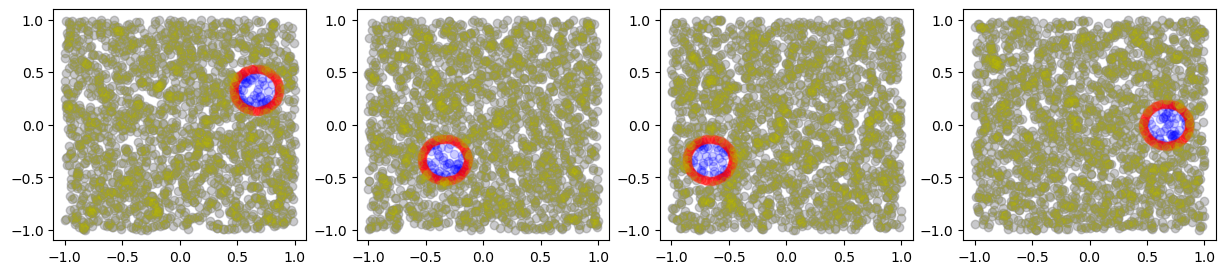

In [9]:

from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, x_branch, y_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [10]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=50,
    branch_layers=1*[50],
    trunk_layers=1*[50],
    root_layers=[50, 20]
)

In [11]:
DON.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xt (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 yt (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 concat (Concatenate)           (None, 2)            0           ['xt[0][0]',                     
                                                                  'yt[0][0]']                     
                                                                                                  
 xb (InputLayer)                [(None, 20)]         0           []                           

2023-11-03 10:19:48.580732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-11-03 10:19:48.584143: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


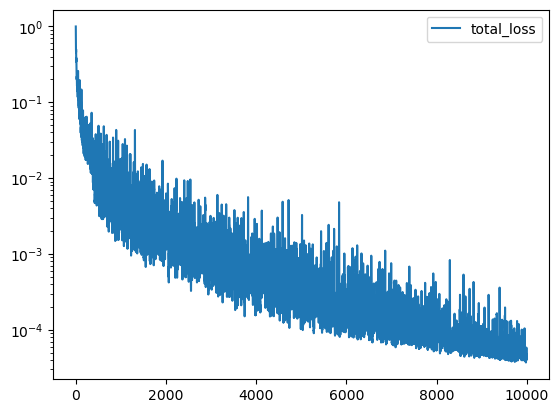

In [12]:
if TRAIN:
    DON.train(dg, epochs=EPOCH_MAX, verbose=0)
    DON.model.save_weights(os.path.join(PATH_NAME, "weights.h5"))
    path = os.path.join(PATH_NAME, 'loss_history.csv')
    pd.DataFrame.from_dict(DON.history.history).to_csv(path, index=False)
    DON.plot_loss()
else:
    DON.model.load_weights(os.path.join(PATH_NAME, "weights.h5"))

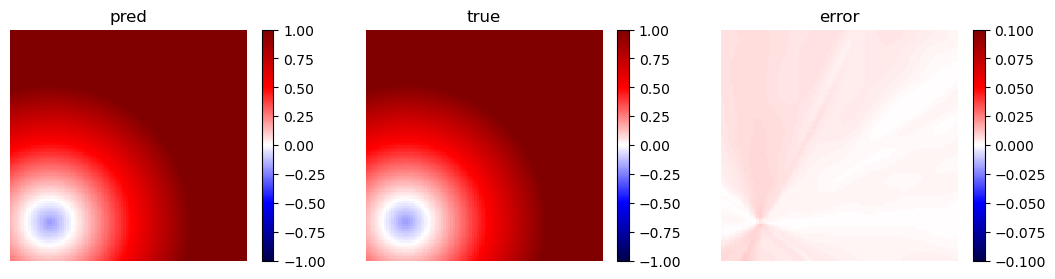

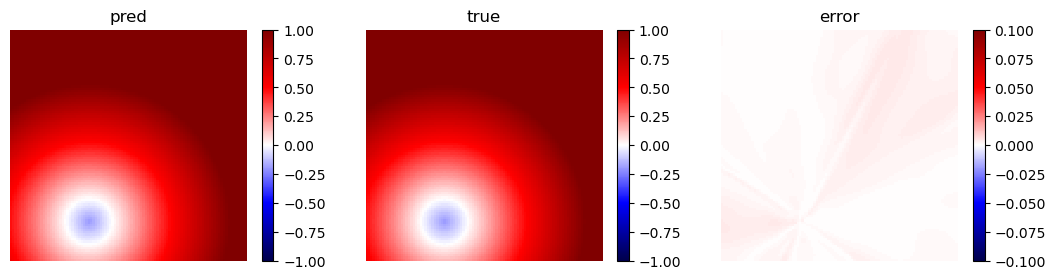

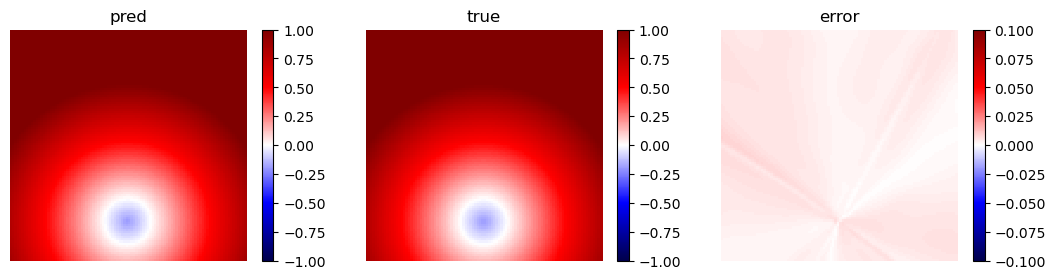

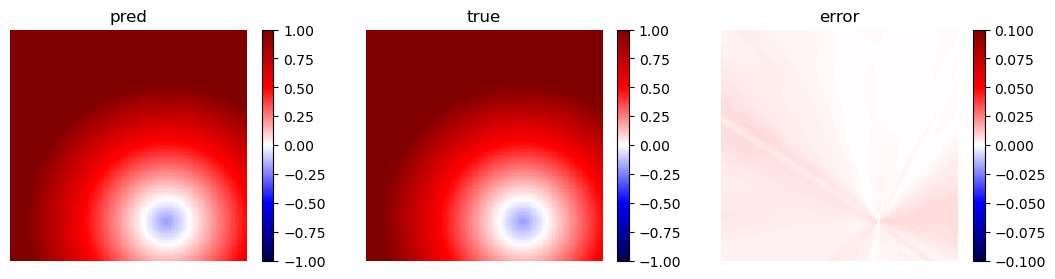

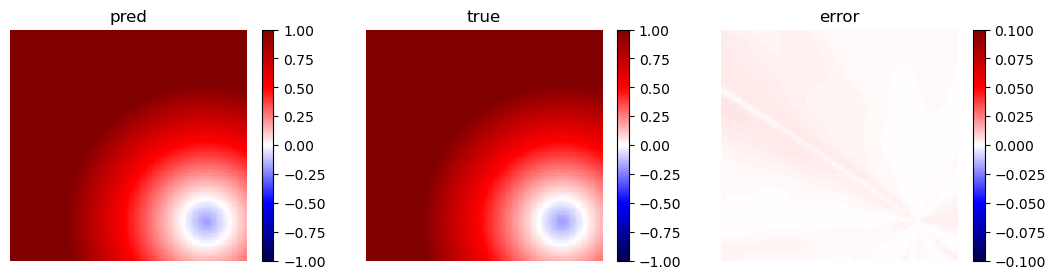

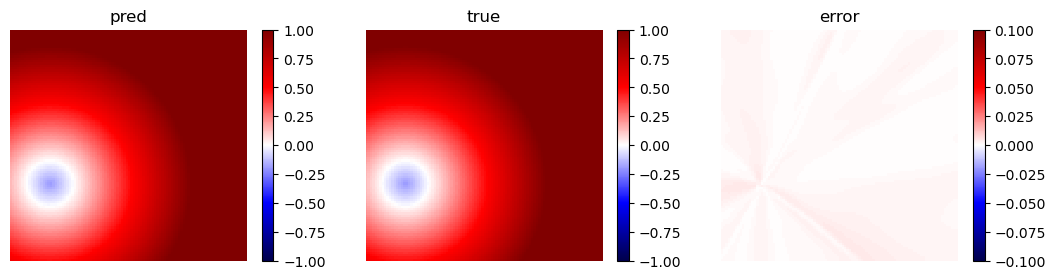

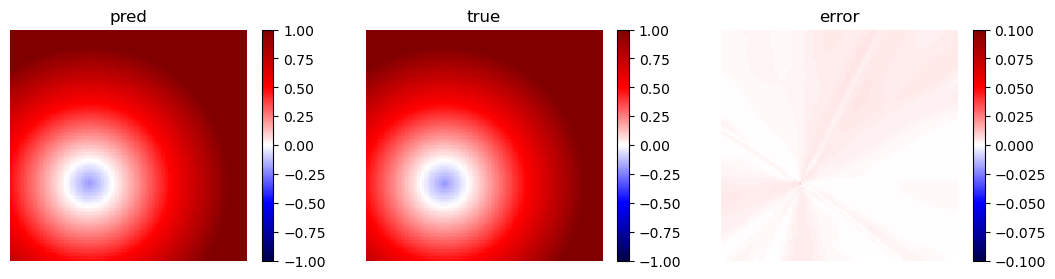

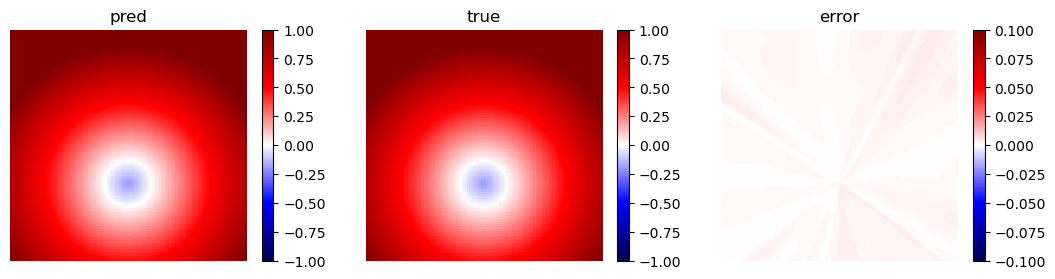

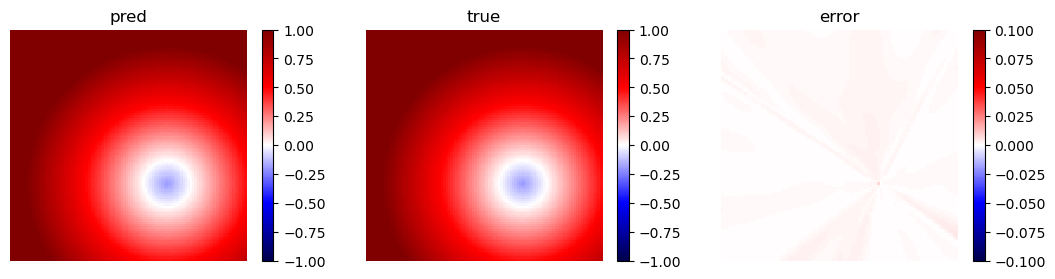

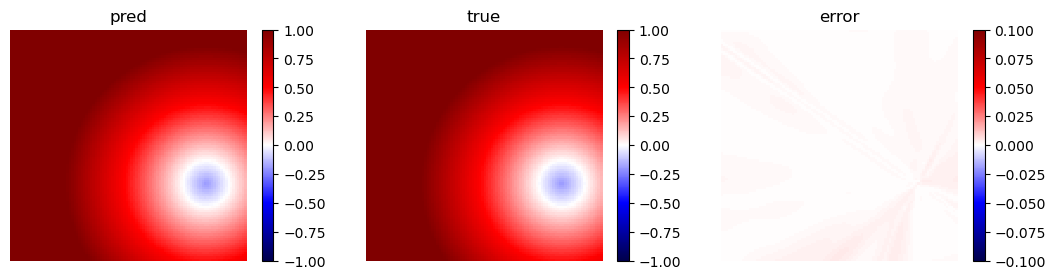

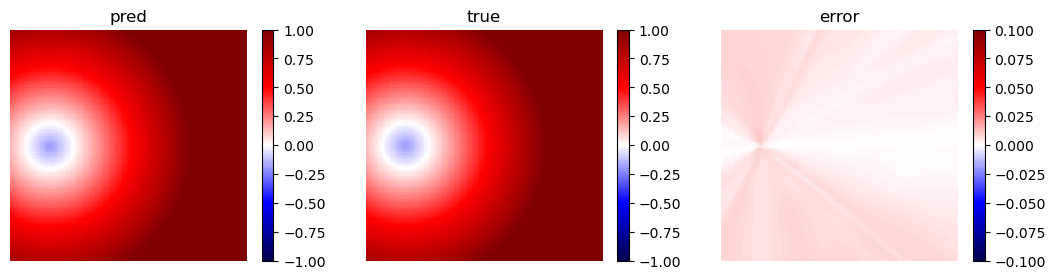

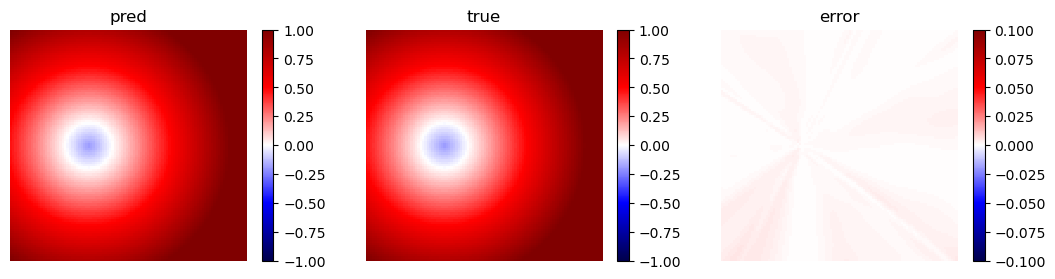

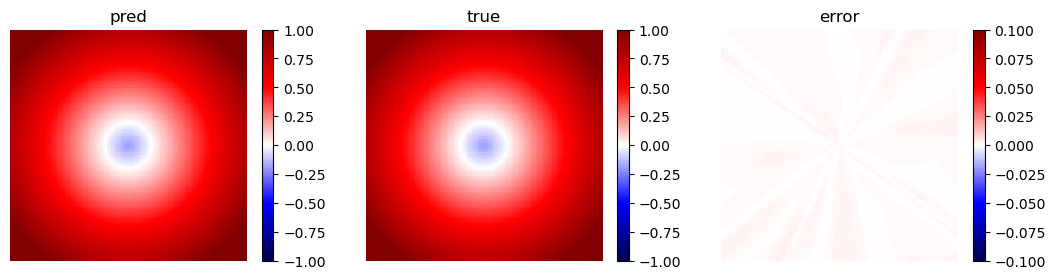

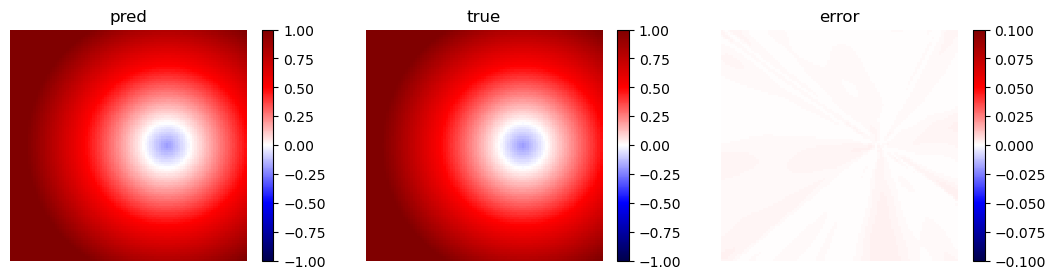

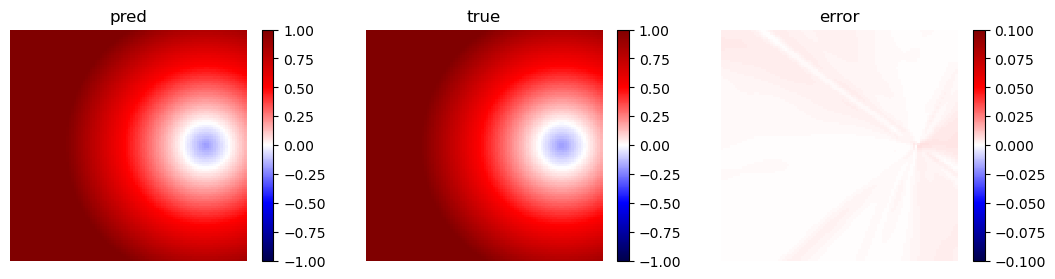

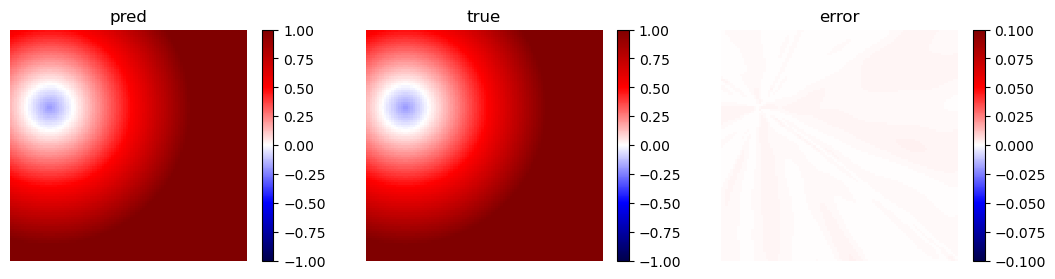

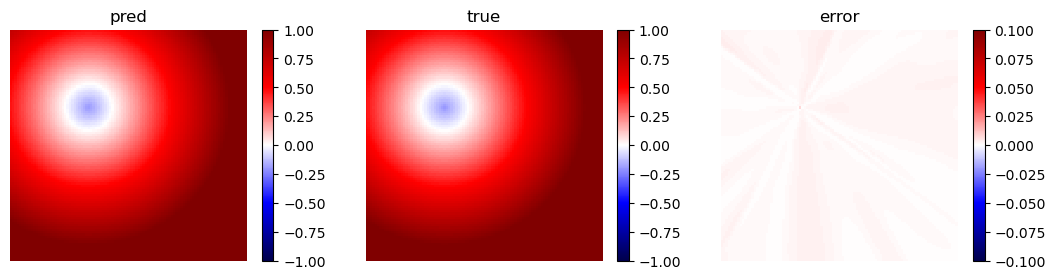

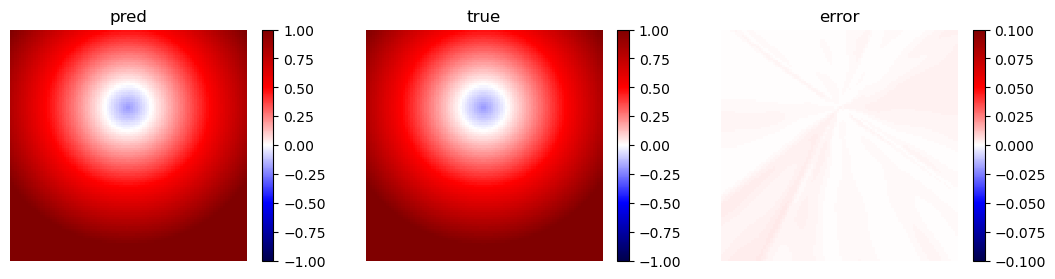

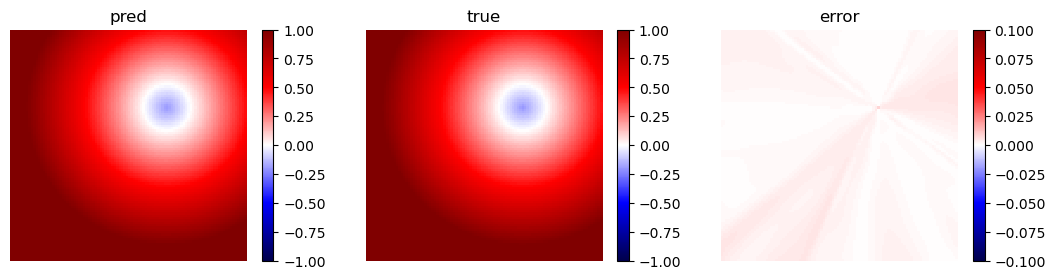

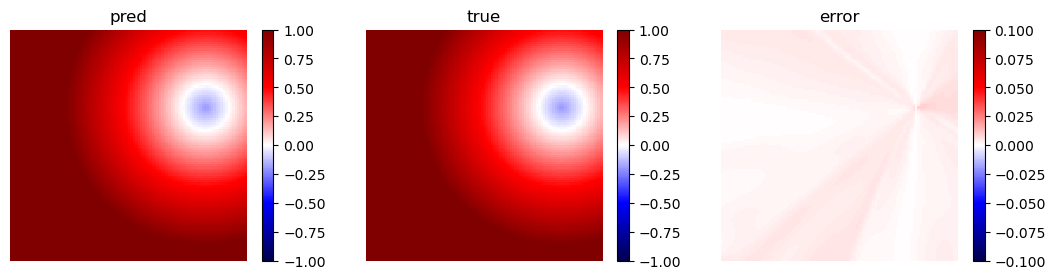

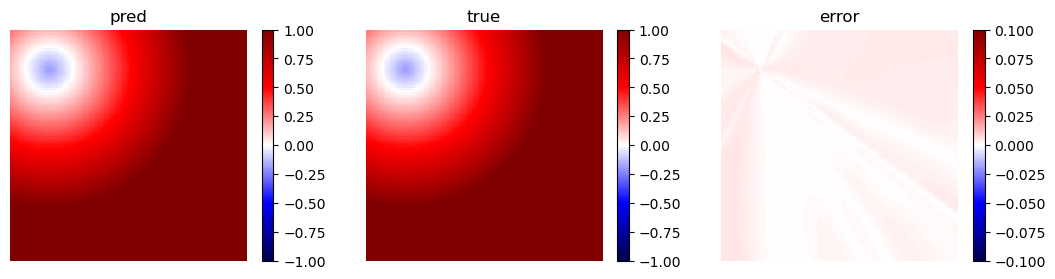

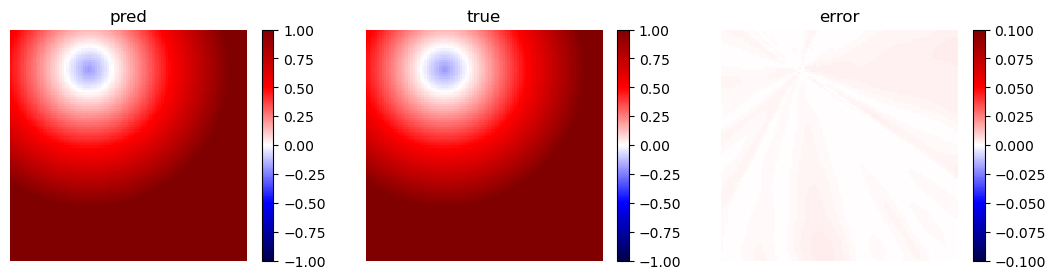

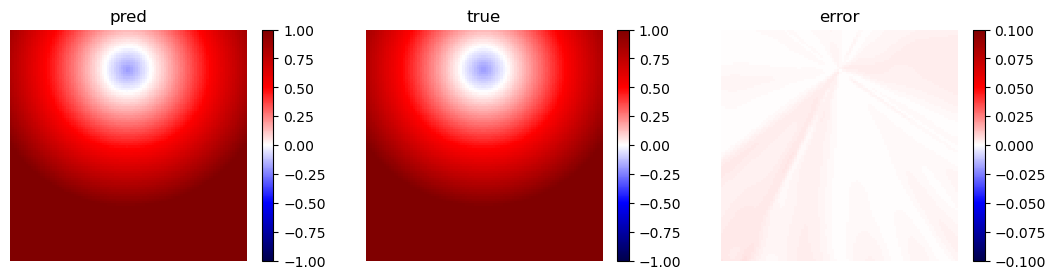

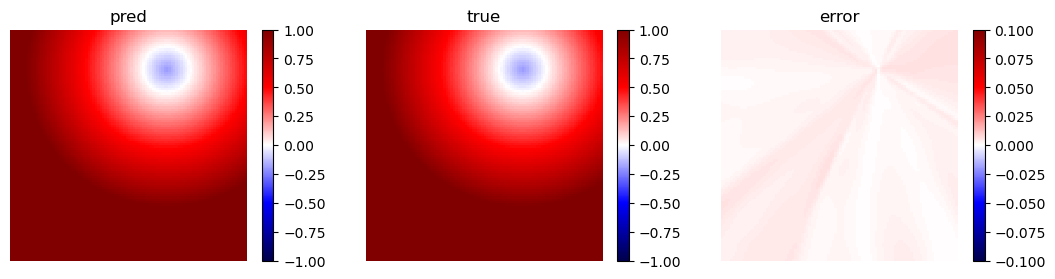

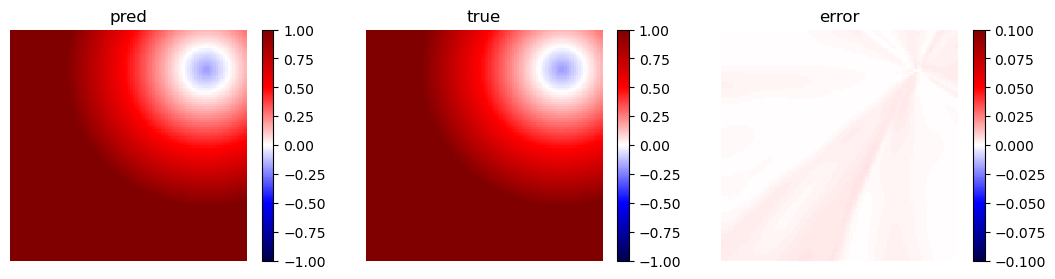

In [13]:
Nx, Ny = 100, 100

grid_x = np.linspace(-1., 1.0001, 7)[1:-1] # del boundary nodes
grid_y = np.linspace(-1., 1.0001, 7)[1:-1] # del boundary nodes
x_source, y_source = [x.flatten() for x in np.meshgrid(grid_x, grid_y)]
mse_error = []

for Xs, Ys in zip(x_source, y_source):
    r = dg._radius
    test_data = dg.generate_test_data(Xs, Ys, Nx=100, Ny=100, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    exact = np.sqrt((x_test - Xs)**2 + (y_test - Ys)**2) - r

    fig, ax = plt.subplots(1, 3, figsize=(13, 3))
    ax0 = ax[0].pcolor(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[0].set_title('pred')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    ax1 = ax[1].pcolor(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[1].set_title('true')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    ax2 = ax[2].pcolor(x_test, y_test, np.abs(exact - pred), cmap='seismic', vmin=-0.1, vmax=0.1)
    ax[2].set_title('error')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax[0].set_ylabel('r = {}'.format(r))
    plt.show()

In [14]:
Nx, Ny = 100, 100

grid_x = np.linspace(-1., 1.0001, 21)[1:-1]
grid_y = np.linspace(-1., 1.0001, 21)[1:-1]
x_source, y_source = [x.flatten() for x in np.meshgrid(grid_x, grid_y)]
mse_error = np.zeros_like(x_source)

for i, (Xs, Ys) in enumerate(zip(x_source, y_source)):
    r = dg._radius
    test_data = dg.generate_test_data(Xs, Ys, Nx=100, Ny=100, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    exact = np.sqrt((x_test - Xs)**2 + (y_test - Ys)**2) - r
    mse_error[i] = np.sqrt(np.mean((pred - exact)**2))


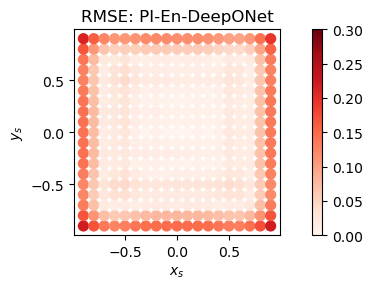

In [15]:
fig = plt.figure(figsize=(4, 3))
im = plt.scatter(x_source, y_source, c=mse_error, s=50, cmap='Reds', vmin=0, vmax=0.3)
plt.title('RMSE: PI-En-DeepONet')
plt.colorbar(im)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x_s$')
plt.ylabel('$y_s$')
plt.axis('square')
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'result_rmse.pdf'))
plt.show()

In [16]:
path_to_losses = [
    "DeepONet_Eikonal-pinn/loss_history.csv",
    "EnDeepONet_Eikonal-pinn/loss_history.csv",
]

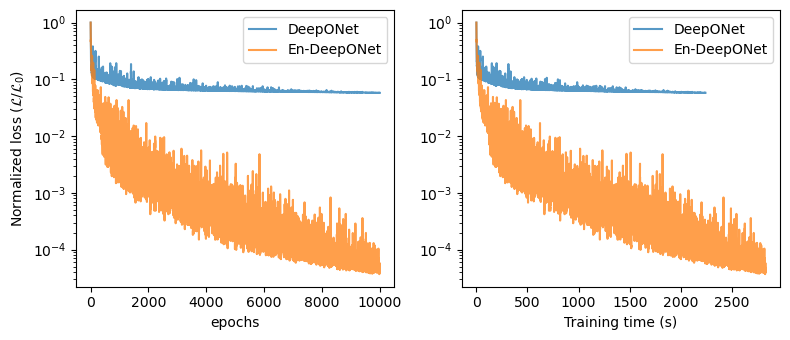

In [17]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5))
for f, label in zip(path_to_losses, ["DeepONet", "En-DeepONet"]):
    df = pd.read_csv(f)
    loss_val = np.array(df['loss'])/df['loss'][0]
    ax[0].semilogy(loss_val, alpha=0.75, label=label)
    ax[1].semilogy(np.cumsum(df['time']), loss_val, alpha=0.75, label=label)

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Normalized loss ($\mathcal{L}/\mathcal{L}_0$)')
ax[1].set_xlabel('Training time (s)')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'results.pdf'))